<a href="https://colab.research.google.com/github/24092/Proyecto-Taller-Etapa-1/blob/main/Proyecto_Final06_10_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: [Johan Rodríguez](https://github.com/Johanx22x)

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [ ]:
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot
from datetime import datetime


# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=0b588c191ceb31532dba724fc65b2469cfff62ee0e573804e6cce6d030e3d82f
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


# Utils

## In-memory data

In [ ]:
registered_faces = {}
registered_face_estudent = {}
registered_faces_estudent ={}
registered_professor = []
registered_estudent = []
registered_misceláneao = []
registered_aula = []
registered_curso = []
attendance_report = []

# Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# face recognition

In [ ]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

# Real time streaming

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [ ]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register Faces

In [ ]:

# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]


upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)

In [ ]:
print(registered_faces)

{'Joshua': array([-9.93811935e-02,  8.65473524e-02,  6.79223239e-02, -2.20494345e-04,
       -3.77539843e-02,  3.16665769e-02, -4.48350161e-02, -5.42936772e-02,
        1.44040048e-01, -1.08150125e-01,  2.86373407e-01,  8.72928649e-04,
       -2.72871345e-01, -2.21293032e-01, -1.69948563e-02,  1.12583950e-01,
       -1.18750125e-01, -1.30539805e-01, -2.26984918e-03, -2.87730247e-02,
        3.67111824e-02, -1.21439788e-02,  3.05055827e-02,  5.01526147e-03,
       -1.48901343e-01, -4.40617085e-01, -8.89606029e-02, -1.15577087e-01,
       -1.57572478e-02, -1.66909248e-01, -2.45555788e-02,  4.32549044e-02,
       -1.53807119e-01, -5.67214452e-02, -1.74861178e-02,  7.55140930e-02,
       -2.24035084e-02,  3.72816175e-02,  1.52825326e-01,  5.48457541e-02,
       -1.66572914e-01,  2.38184333e-02,  1.86716542e-02,  2.91208923e-01,
        1.35494247e-01,  7.07538277e-02,  2.55292710e-02, -2.77808905e-02,
        1.40219495e-01, -2.65238762e-01,  7.56433681e-02,  1.09540179e-01,
        1.4858

# Registered_Person

In [ ]:
def agregar_persona(type):
    print("informacion adicional de: ", registered_name)
    cedula = input("Ingrese el id: ")
    nombre = registered_name
    fecha= input("Ingrese su fecha de nacimiento(D/M/A): ")
    nacionalidad= input("Ingrese su nacionalidad ")
    telefono= input("Ingrese su numero de telefono de casa: ")
    celular=input("Ingrese su numero de celular: ")
    telefonos={"casa": telefono,        #diccionario para agregar los dos numeros de telefono
                "celular": celular
              }
    cant = int(input("cuantos correos electronicos desea agregar? ")) #Para crear listas con correos dependiendo de cuantos el usuario quiere ingresar
    imails = []
    while cant >0:
      imail = input("Ingrese su dirección de correo electronico: ")
      imails.append(imail)
      cant-=1
    direccion= input("Ingrese su dirección: ")

    if type == "profesor":
      especialidad= input("Ingrese su especialidad: ")
      estado= input("Ingrese su estado civil: ")   #adicional
      asignatura = input("Ingrese la asignatura que enseña: ") #adicional

      # Crear un diccionario con la información del profesor
      profesor = {
          "nombre": nombre,
          "Identificacion": cedula,
          "Fecha de nacimiento": fecha,
          "Nacionalidad": nacionalidad,
          "Números de teléfono y celular": telefonos,
          "imail ": imails,
          "Dirección": direccion,
          "Especialidad": especialidad,
          "Estado civil": estado,
          "Asignatura que enseña": asignatura,
          }
      registered_professor.append(profesor)
      registered_face_estudent=registered_faces[registered_name]
      registered_faces_estudent[registered_name] = registered_face_estudent
      print("Profesor agregado exitosamente.")
    elif type == "estudiante":
      carrera= input("Ingrese su carrera: ")
      genero= input("Ingrese su genero: ")   #adicional
      estatura= input("Ingrese su estatura: ") #adicional
      edad=int(input("Ingrese la edad del estudiante: "))
      estudiante = {
            "nombre": nombre,
            "Identificacion": cedula,
            "Fecha de nacimiento": fecha,
            "Nacionalidad": nacionalidad,
            "Números de teléfono y celular": telefonos,
            "Dirección": direccion,
            "carrera": carrera,
            "edad": edad,
            "Genero": genero,
            "Estatura del estudiante": estatura,

            }
      registered_estudent.append(estudiante)
      registered_face_estudent=registered_faces[registered_name]
      registered_faces_estudent[registered_name] = registered_face_estudent
      print("Estudiante agregado exitosamente.")

    elif type == 'micelaneo':
      turno= input("Ingrese el turno en el que trabaja: ")
      genero= input("Ingrese su genero: ")   #adicional
      estatura= input("Ingrese su estatura: ") #adicional


      # Crear un diccionario con la información del miscelaneo
      miselaneo = {
          "nombre": nombre,
          "Identificacion": cedula,
          "Fecha de nacimiento": fecha,
          "Nacionalidad": nacionalidad,
          "Números de teléfono y celular": telefonos,
          "Dirección": direccion,
          "Turno": turno,
          "Genero": genero,
          "Estatura del miscelaneo": estatura,
          }
      registered_misceláneao.append(miselaneo)
      registered_face_estudent=registered_faces[registered_name]
      registered_faces_estudent[registered_name] = registered_face_estudent
      print("miscelaneo agregado exitosamente.")

# Buscar Profesor y estudiantes

In [ ]:
## funcion para buscar profesor
def buscar_profesor(registered_professor, name):
    for i in registered_professor:
        if i["nombre"] == name:
            return i
    return None
## funcion para buscar estudiante
def buscar_estudiante(registered_estudent, name):
    for estudiante in registered_estudent:
        if estudiante["nombre"] == name:
            return estudiante
    return None
## funcion para buscar miscelaneo
def buscar_micelaneo(registered_misceláneao, name):
    for micelaneo in registered_misceláneao:
        if micelaneo["nombre"] == name:
            return micelaneo
    return None

# Registrar Aula y curso

In [ ]:
def agregar_aula():
    print("informacion adicional del aula")
    numero_de_aula = input("Ingrese el número de aula: ")
    miselaneo = int(input("Digite cuantos miselaneos limpian esta aula: "))
    miselan =[]
    for i in range(1, miselaneo + 1):
        while True:
            horario = input("cual es el horario correspondiente de la siguiente miselanea: ")
            nombre_miselaneo = input("Ingrese el nombre del miselaneo #" + str(i) + " que limpia: ")
            micelaneo = buscar_micelaneo(registered_misceláneao, nombre_miselaneo)
            if micelaneo is not None:
                micelaneos = {
                    "horario":horario,
                   "miselaneo correspondiente": nombre_miselaneo
                }
                miselan.append(micelaneos)
                break
            else:
                print("Ese profesor no está registrado. Por favor, inténtelo nuevamente.")

    # Crear un diccionario con la información del miscelaneo
    aula = {
        "número de aula": numero_de_aula,
        "miselaneo": miselan,
        }
    registered_aula.append(aula)
    print("aula agregada exitosamente.")


def agregar_curso():
    print(" --- Crear curso ---")
    lista_estudiantes = []
    lista_profesores = []
    codigo = int(input("Ingrese el codigo del curso: "))
    nombre = input("Ingrese el nombre del curso: ")
    periodo = int(input("Ingrese el periodo: "))
    carrera = input("A qué carrera pertenece el curso: ")
    prof = int(input("Digite cuantos profesores hay en el curso: "))

    # Utilizar prof + 1 en el rango del bucle para profesores
    for i in range(1, prof + 1):
        while True:
            nombre_profesor = input("Ingrese el nombre del profesor #" + str(i) + " que está en el curso: ")
            profesor = buscar_profesor(registered_professor, nombre_profesor)
            if profesor is not None:
                lista_profesores.append(profesor)
                break
            else:
                print("Ese profesor no está registrado. Por favor, inténtelo nuevamente.")


    opcion1 = int(input("Digite cuantos estudiantes hay en el curso: "))

    # Utilizar opcion1 + 1 en el rango del bucle para estudiantes
    for i in range(1, opcion1 + 1):
        while True:
            nombre_estudiante = input("Ingrese el nombre del estudiante #" + str(i) + " que está en el curso: ")
            estudiante = buscar_estudiante(registered_estudent, nombre_estudiante)
            if estudiante is not None:
                lista_estudiantes.append(estudiante)
                break
            else:
                print("Ese estudiante no está registrado. Por favor, inténtelo nuevamente.")

    horario = input("Ingrese el horario de lecciones: ")
    aula = input("Ingrese el aula donde se imparte: ")
    curso = {
        "codigo": codigo,
        "nombre": nombre,
        "periodo": periodo,
        "carrera": carrera,
        "estudiantes": lista_estudiantes,
        "profesores": lista_profesores,  # Utilizar lista_profesores en lugar de profesor
        "horario": horario,
        "aula": aula
    }
    registered_curso.append(curso)
    print("Curso agregado exitosamente.")


##Ordenamientos

In [ ]:
##ordenamiento burbuja para consulta 7
def ordenamiento_burbuja(lista):
  for curso in registered_curso:
    estudiantes = curso['estudiantes']
    pasadas=len(estudiantes) -1
    while pasadas > 0:
      pos=0
      while pasadas > pos:
        if estudiantes[pos]['edad'] > estudiantes[pos+1]['edad']:
          temp=estudiantes[pos]
          estudiantes[pos]=estudiantes[pos+1]
          estudiantes[pos+1]=temp
        pos+=1
      pasadas-=1

ordenamiento_burbuja(registered_curso)



## ordenamiento por insercion para consulta 8

def ordenamiento_insercion(lista):
    for curso in lista:
        estudiantes = curso['estudiantes']
        for i in range(1, len(estudiantes)):
            estudiante_actual = estudiantes[i]
            edad_estudiante_actual = estudiante_actual['edad']
            j = i - 1
            while j >= 0 and edad_estudiante_actual > estudiantes[j]['edad']:
                estudiantes[j + 1] = estudiantes[j]
                j -= 1
            estudiantes[j + 1] = estudiante_actual
ordenamiento_insercion(registered_curso)


""" estos ordenamientos están diseñados para ordenar los diccionarios
que se almacenaron en las listas """





' estos ordenamientos están diseñados para ordenar los diccionarios\nque se almacenaron en las listas '

# consulta 6,9, 10 y 11: recorrer despues del reconocimiento facial

In [ ]:
import cv2
##consulta 6. todas las personas que se reportaron a la asistencia
def buscar_informacion(nombre, registros):
    for registro in registros:
        if registro['nombre'] == nombre:
            return registro
    return None
## funcion para mostrar la imagen de cada persona con la informacion
def mostrar_reporte(match_info, path_cuadro, registered_estudent, registered_professor, registered_misceláneao):
    print("Caras del reporte de asistencia")
    for img_path, faces_list in path_cuadro:
        img = cv2.imread(img_path)
        for face_rectangle in faces_list:
            left, top, right, bottom = face_rectangle['x1'], face_rectangle['y1'], face_rectangle['x2'], face_rectangle['y2']
            match_name = None
            current_time = None
            for match in match_info:
                if img_path == match[1]:
                    match_name = match[0]
                    current_time = match[2]
                    break
            if match_name and current_time:
                cv2.rectangle(
                    img,
                    (left, top),
                    (right, bottom),
                    (0, 255, 0),
                    2,
                )
                text = f'Nombre: {match_name}\nFecha y hora: {current_time}'
                cv2.putText(img, text, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Buscar el diccionario completo en el nombre
                info_estudiante = buscar_informacion(match_name, registered_estudent)
                info_profesor = buscar_informacion(match_name, registered_professor)
                info_miscelaneo = buscar_informacion(match_name, registered_misceláneao)

                if info_estudiante:
                    print(f'Información detallada para {match_name} (Estudiante):')
                    print(info_estudiante)
                elif info_profesor:
                    print(f'Información detallada para {match_name} (Profesor):')
                    print(info_profesor)
                elif info_miscelaneo:
                    print(f'Información detallada para {match_name} (Misceláneo):')
                    print(info_miscelaneo)
                else:
                    print(f'No se encontró información detallada para {match_name}')

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()





## funcion para consulta 9
def encontrar_mas_reportado(match_info):

    counts = {}
    for info in match_info:
        nombre = info[0]
        if nombre in counts:
            counts[nombre] += 1
        else:
            counts[nombre] = 1
    mas_reportado = ""
    max_ocurrencias = 0

    for nombre, ocurrencias in counts.items():
        if ocurrencias > max_ocurrencias:
            max_ocurrencias = ocurrencias
            mas_reportado = nombre

    return mas_reportado, max_ocurrencias

## funcion para consulta 10
##encuentra el menos reportado
def encontrar_menos_reportado(match_info):

    counts = {}
    for info in match_info:
        nombre = info[0]
        if nombre in counts:
            counts[nombre] += 1
        else:
            counts[nombre] = 1

    menos_reportado = ""
    min_ocurrencias = float('inf')

    for nombre, ocurrencias in counts.items():
        if ocurrencias < min_ocurrencias:
            min_ocurrencias = ocurrencias
            menos_reportado = nombre

    return menos_reportado, min_ocurrencias
## consulta 11, funcion encuentra el curso con más estudiantes
def encontrar_curso_con_mas_estudiantes(registered_curso):
    curso_con_mas_estudiantes = ""
    max_estudiantes = 0

    for curso in registered_curso:
        nombre_curso = curso["nombre"]
        if "estudiantes" in curso:
            estudiantes = curso["estudiantes"]
        else:
            estudiantes = []
        num_estudiantes = len(estudiantes)

        if num_estudiantes > max_estudiantes:
            max_estudiantes = num_estudiantes
            curso_con_mas_estudiantes = nombre_curso

    return curso_con_mas_estudiantes, max_estudiantes
## funcion para imprimir las fotos de los estudiantes registrados en el curso con más estudiantes
## es el mismo codigo para la consulta 6, pero solamente imprime los rostros de los estudiantes registrados en el curso(es lo que se solicita)
def mostrar_reportes_curso(match_info, path_cuadro, registered_estudent, registered_professor=None, registered_misceláneao=None):
    print("Fotos de estudiantes con sus nombres:")
    for img_path, faces_list in path_cuadro:
        img = cv2.imread(img_path)
        for face_rectangle in faces_list:
            left, top, right, bottom = face_rectangle['x1'], face_rectangle['y1'], face_rectangle['x2'], face_rectangle['y2']
            match_name = None
            current_time = None
            for match in match_info:
                if img_path == match[1]:
                    match_name = match[0]
                    current_time = match[2]
                    break
            if match_name and current_time:
                # Buscar el diccionario completo con el nombre
                info_estudiante = buscar_informacion(match_name, registered_estudent)

                # Verificar si la persona es un estudiante
                if info_estudiante:
                    cv2.rectangle(
                        img,
                        (left, top),
                        (right, bottom),
                        (0, 255, 0),
                        2,
                    )
                    text = f'Nombre: {match_name}\nFecha y hora: {current_time}'
                    cv2.putText(img, text, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                    # Mostrar la foto solo si es un estudiante
                    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    plt.show()

    nombre_curso_mas_estudiantes, num_estudiantes = encontrar_curso_con_mas_estudiantes(registered_curso)
    print(f"El curso con más estudiantes es '{nombre_curso_mas_estudiantes}' con {num_estudiantes} estudiantes.")



# Menús

     Menú:     
 Ingrese donde quiere agregar a la persona registada anteriormente: 
1. Profesor(a)
2. Estudiante
3. Miscelaneo/a
4. aula
5. curso
6. Consultas
7. Salir
Selecciona una opción: 6
Bienvenido al menú de consultas: 
 1. lista de profesores: 
 2. lista de estudiantes: 
 3. lista de miscelaneos: 
 4. lista de aulas: 
 5. lista de cursos: 
 6. Reporte de asistencia: 
 7. Estudiantes matriculados(forma ascendente por edad).  
 8. Estudiantes matriculados(forma descendente por edad). 
 9. Record de estudiante que más veces asistió a un curso: 
 10. Record de estudiante que menos veces asistió a un curso: 
 11. Hora de más personas reportadas en un curso 
 12. Profesores con sus cursos correspondientes 
 13. Salir de consultas. 
 Seleccione una opción: 11
Fotos de estudiantes con sus nombres:


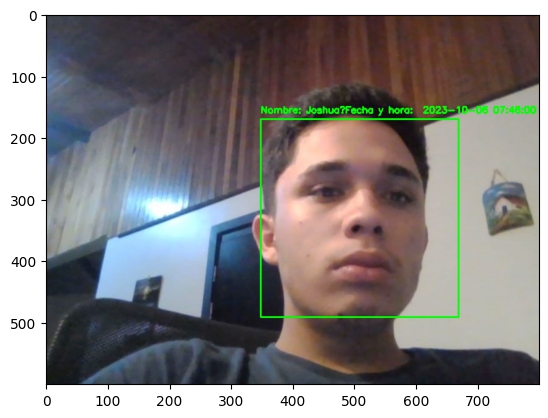

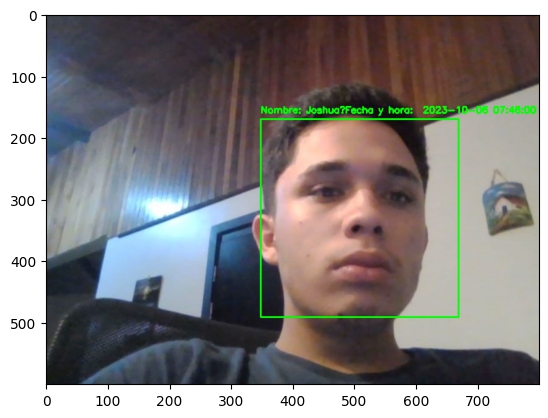

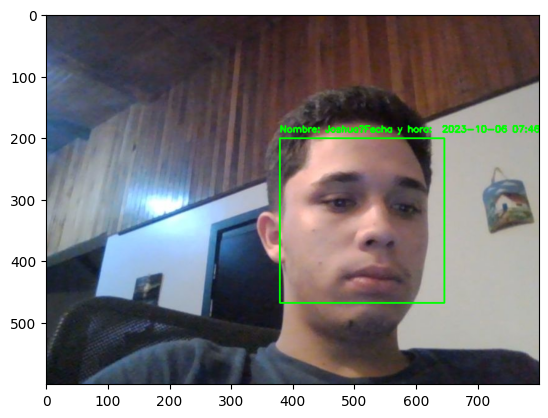

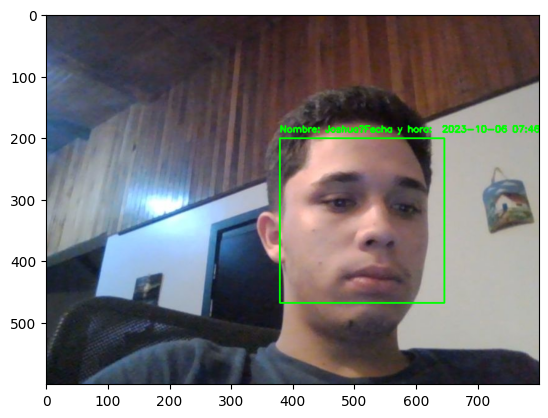

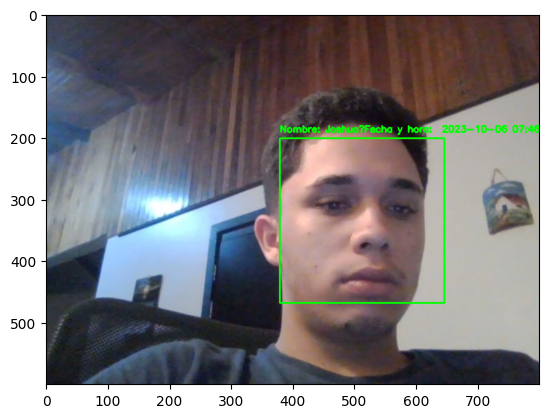

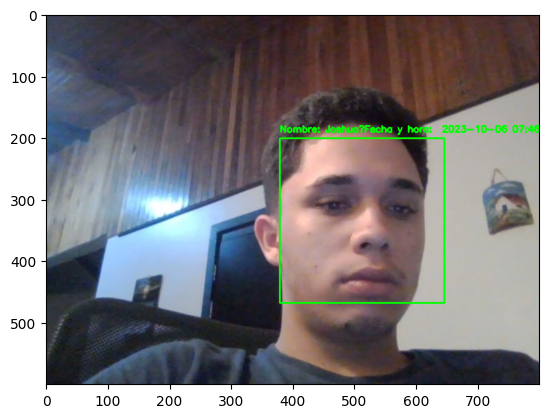

El curso con más estudiantes es 'ca' con 2 estudiantes.
 1. lista de profesores: 
 2. lista de estudiantes: 
 3. lista de miscelaneos: 
 4. lista de aulas: 
 5. lista de cursos: 
 6. Reporte de asistencia: 
 7. Estudiantes matriculados(forma ascendente por edad).  
 8. Estudiantes matriculados(forma descendente por edad). 
 9. Record de estudiante que más veces asistió a un curso: 
 10. Record de estudiante que menos veces asistió a un curso: 
 11. Hora de más personas reportadas en un curso 
 12. Profesores con sus cursos correspondientes 
 13. Salir de consultas. 


KeyboardInterrupt: ignored

In [ ]:

def consultas():
  print("Bienvenido al menú de consultas: ")
  cont = 10
  while cont > 0:
    print(" 1. lista de profesores: ")
    print(" 2. lista de estudiantes: ")
    print(" 3. lista de miscelaneos: ")
    print(" 4. lista de aulas: ")
    print(" 5. lista de cursos: ")
    print(" 6. Reporte de asistencia: ")
    print(" 7. Estudiantes matriculados(forma ascendente por edad).  ") # ordenamiento burbuja
    print(" 8. Estudiantes matriculados(forma descendente por edad). ") # ordenamiento por inserción
    print(" 9. Record de estudiante que más veces asistió a un curso: ")
    print(" 10. Record de estudiante que menos veces asistió a un curso: ")
    print(" 11. Hora de más personas reportadas en un curso ") #indicar la cantidad de personas (mostrar la información de cada persona) y mostrar una imagen con un cuadro con el nombre de cada persona.
    print(" 12. Profesores con sus cursos correspondientes ") # presentar una lista con todos los cursos que imparte(elegida por los autores)
    print(" 13. Salir de consultas. ")

    op = int(input(" Seleccione una opción: "))
    if op ==1:
      print(registered_professor)
    elif op == 2:
      print(registered_estudent)
    elif op == 3:
      print(registered_misceláneao)
    elif op == 4:
      print(registered_aula)
    elif op == 5:
      print(registered_curso)
    elif op == 6:
      mostrar_reporte(match_info, path_cuadro, registered_estudent, registered_professor, registered_misceláneao)

    elif op == 7:
      ordenamiento_burbuja(registered_curso)
      print(registered_curso)
    elif op == 8:
      ordenamiento_insercion(registered_curso)
      print(registered_curso)
    elif op == 9:
      mas_reportado, max_ocurrencias = encontrar_mas_reportado(match_info)
      info_estudiante_mas_reportado = None
      for estudiante in registered_estudent:
          if estudiante['nombre'] == mas_reportado:
              info_estudiante_mas_reportado = estudiante
              break

      # Imprimir la información detallada si se encontró
      if info_estudiante_mas_reportado:
          print(f'Información detallada para el más reportado (Estudiante):')
          print(info_estudiante_mas_reportado)
      else:
          print(f'No se encontró información detallada para el más reportado')


      print(f"{mas_reportado} fue la persona más reportada con {max_ocurrencias} asistencias.")
    elif op == 10:
      menos_reportado, min_ocurrencias = encontrar_menos_reportado(match_info)
      info_estudiante_menos_reportado = None
      for estudiante in registered_estudent:
          if estudiante['nombre'] == menos_reportado:
              info_estudiante_menos_reportado = estudiante
              break

      # Imprimir la información detallada si se encontró
      if info_estudiante_menos_reportado:
          print(f'Información detallada para el menos reportado (Estudiante):')
          print(info_estudiante_menos_reportado)
      else:
          print(f'No se encontró información detallada para el menos reportado')
      print(f"{menos_reportado} fue la persona menos reportada con {min_ocurrencias} asistencias.")

    elif op == 11:
## utiliza las caras registradas y que fueron guardadas en el google drive despues de correr el reconocimiento facial(reporte de asistencia)
      mostrar_reportes_curso(match_info, path_cuadro, registered_estudent, registered_professor, registered_misceláneao)

    elif op == 12:
       profesores_cursos = {}
       for curso in registered_curso:
          names = curso["nombre"]
          teachers = curso["profesores"]

          for teacher in teachers:
              names_teacher = teacher["nombre"]

              if names_teacher in profesores_cursos:
                  profesores_cursos[names_teacher].add(names)
              else:
                  profesores_cursos[names_teacher] = {names}

       for teacher, cursos in profesores_cursos.items():
          print(f"El profesor {teacher} imparte los siguientes cursos: {list(cursos)}")  ##mostrar una lista de todos los cursos que da un profesor

    elif op == 13:
      print("saliendo de consultas.....")
      break
    else:
        print("Opción no válida. Por favor, selecciona una opción válida.")

## menu para el registro de personas e interaccion
cont = 10
while cont > 0:
    print("     Menú:     ")
    print(" Ingrese donde quiere agregar a la persona registada anteriormente: ")
    print("1. Profesor(a)")
    print("2. Estudiante")
    print("3. Miscelaneo/a")
    print("4. aula")
    print("5. curso")
    print("6. Consultas")
    print("7. Salir")

    opcion = int(input("Selecciona una opción: "))

    if opcion ==1:
      agregar_persona("profesor")
    elif opcion == 2:
      agregar_persona("estudiante")
    elif opcion == 3:
      agregar_persona("micelaneo")
    elif opcion == 4:
      agregar_aula()
    elif opcion == 5:
      agregar_curso()
    elif opcion == 6:
      consultas()
    elif opcion == 7:
      print("saliendo del programa ....")
      registered_faces = {}
      break
    else:
        print("Opción no válida. Por favor, selecciona una opción válida.")

# Recognize Faces: REPORTE DE ASISTENCIA

<IPython.core.display.Javascript object>

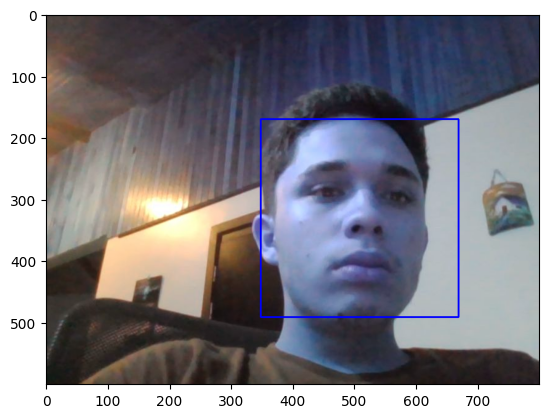

Reporte de asistencia con reconocimiento facial: 
Joshua  2023-10-06 07:46:00 


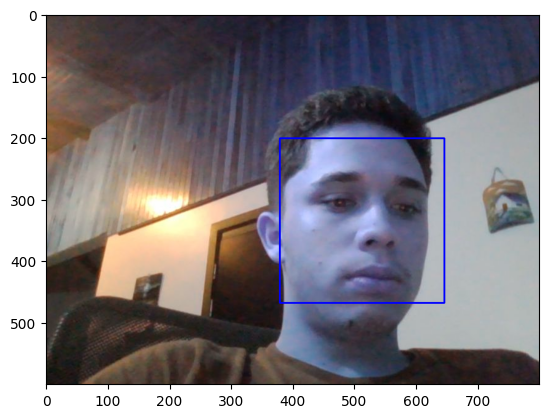

Reporte de asistencia con reconocimiento facial: 
Joshua  2023-10-06 07:46:03 


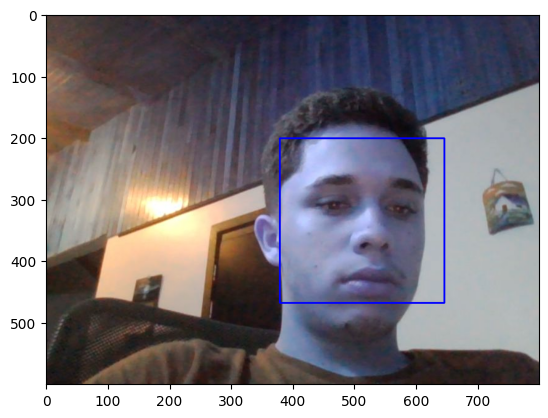

Reporte de asistencia con reconocimiento facial: 
Joshua  2023-10-06 07:46:05 


In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''
i=0

match_info = []
path_cuadro = []
while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])
  # Get the face locations from the frame
  face_locations = face_recognition.face_locations(frame)

  img_path = '/content/drive/MyDrive/proyecto taller' + 'frame'+str(i)+'.jpg'
  cv2.imwrite(img_path ,frame)

  # For each face in the frame
  for (top, right, bottom, left) in face_locations:
      # Draw a rectangle around the face
      cv2.rectangle(
          frame,
          (left, top),
          (right, bottom),
          (0, 0, 255),
          2,
      )
      # Get the face encoding of the face
      face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

      # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(registered_faces_estudent.values()), face_encoding)

      # If there is a match
      if True in matches:
        if True in matches:
          faces_list = []
          for face_location in face_locations:  # Itera sobre las coordenadas de todas las caras
              top, right, bottom, left = face_location
              img_with_rectangle = cv2.rectangle(frame.copy(), (left, top), (right, bottom), (0, 255, 0), 2)
              face_rectangle = {'x1': left, 'y1': top, 'x2': right, 'y2': bottom}
              faces_list.append(face_rectangle)
              path_cuadro.append([img_path, faces_list])


              # Get the index of the match
              match_index = matches.index(True)
              # Get the name of the match
              match_name = list(registered_faces_estudent.keys())[match_index]

              current_time = datetime.now().strftime(" %Y-%m_%d %H:%M:%S ")
              match_info.append([match_name, path_cuadro, current_time])


              # Get the name of the match
              match_name = list(registered_faces_estudent.keys())[match_index]

              current_time = datetime.now().strftime(" %Y-%m-%d %H:%M:%S ")

              # Agrega la información a las listas
              match_info.append([match_name, img_path, current_time])
              path_cuadro.append([img_path, faces_list])

  # Show image
  plt.imshow(frame)
  plt.show()
  print("Reporte de asistencia con reconocimiento facial: ")
  print(match_name, current_time)
  i+=1

## Reporte de asistencia

In [ ]:
## la lista con sublistas donde se almacena toda la informacion del reporte(nombre, fecha y hora)
print(match_info)

[['Joshua', [['/content/drive/MyDrive/proyecto tallerframe0.jpg', [{'x1': 348, 'y1': 170, 'x2': 669, 'y2': 491}]], ['/content/drive/MyDrive/proyecto tallerframe0.jpg', [{'x1': 348, 'y1': 170, 'x2': 669, 'y2': 491}]], ['/content/drive/MyDrive/proyecto tallerframe1.jpg', [{'x1': 379, 'y1': 201, 'x2': 646, 'y2': 468}]], ['/content/drive/MyDrive/proyecto tallerframe1.jpg', [{'x1': 379, 'y1': 201, 'x2': 646, 'y2': 468}]], ['/content/drive/MyDrive/proyecto tallerframe2.jpg', [{'x1': 379, 'y1': 201, 'x2': 646, 'y2': 468}]], ['/content/drive/MyDrive/proyecto tallerframe2.jpg', [{'x1': 379, 'y1': 201, 'x2': 646, 'y2': 468}]]], ' 2023-10_06 07:46:00 '], ['Joshua', '/content/drive/MyDrive/proyecto tallerframe0.jpg', ' 2023-10-06 07:46:00 '], ['Joshua', [['/content/drive/MyDrive/proyecto tallerframe0.jpg', [{'x1': 348, 'y1': 170, 'x2': 669, 'y2': 491}]], ['/content/drive/MyDrive/proyecto tallerframe0.jpg', [{'x1': 348, 'y1': 170, 'x2': 669, 'y2': 491}]], ['/content/drive/MyDrive/proyecto tallerfra